In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.


In [2]:
# change data dir based on machine
local = True
if local is True:
    data_dir = 'data/'
else:
    data_dir = '../input/vsb-power-line-fault-detection/'    

In [3]:
# set parameters
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

# min max values of the signal
max_num = 127
min_num = -128

In [4]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [5]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb
# main attention class
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [6]:
# just load train data
# set index, it makes the data access much faster

df_train = pd.read_csv(data_dir + 'metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head(), len(df_train)

(                      signal_id  target
 id_measurement phase                   
 0              0              0       0
                1              1       0
                2              2       0
 1              0              3       1
                1              4       1,
 8712)

In [7]:
# This function standardize the data from (-128 to 127) to (-1 to 1)
# Theoretically it helps in the NN Model training, but I didn't tested without it
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [9]:
# This is one of the most important peace of code of this Kernel
# Any power line contain 3 phases of 800000 measurements, or 2.4 millions data 
# It would be praticaly impossible to build a NN with an input of that size
# The ideia here is to reduce it each phase to a matrix of <n_dim> bins by n features
# Each bean is a set of 5000 measurements (800000 / 160), so the features are extracted from this 5000 chunk data.
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    new_ts = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        # now, we just add all the features to new_ts and convert it to np.array
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [10]:
# this function take a piece of data and convert using transform_ts(), but it does to each of the 3 phases
# if we would try to do in one time, could exceed the RAM Memmory
def prep_data(start, end):
    # load a piece of data from file
    praq_train = pq.read_pandas(data_dir + 'train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    # using tdqm to evaluate processing time
    # takes each index from df_train and iteract it from start to end
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            # but just append the target one time, to not triplicate it
            if phase == 0:
                y.append(target)
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [20]:
# since 3 phases.Transformed signal is 160x19. X shape  19*3 = 57 
X.shape, y.shape   

((2904, 160, 57), (2904,))

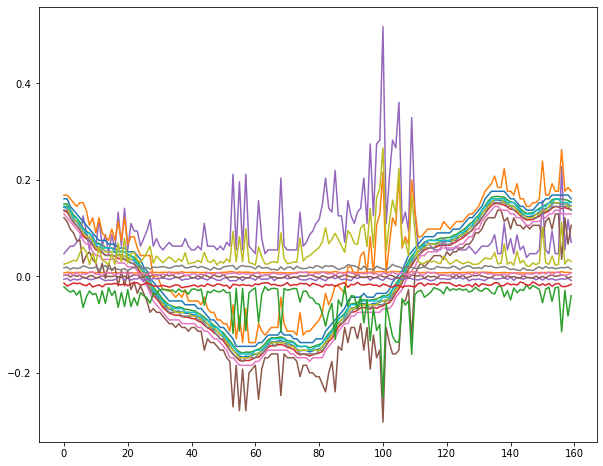

In [10]:
# visualize transformed signals for each phase
praq_train = pq.read_pandas(data_dir + 'train.parquet', columns=[str(i) for i in range(0, 4356)]).to_pandas()

signal_id, target  = df_train.loc[0].loc[0] 

import matplotlib.pyplot as plt
#praq_train[str(signal_id)].plot()

transform_ts(praq_train[str(signal_id)]).shape

# plt.plot(transform_ts(praq_train[str(signal_id)])[:,0])
transformed_sig = transform_ts(praq_train[str(signal_id)]) # has a shape of 160 x 19
plt.figure(figsize=(10, 8))
for i in range(transformed_sig.shape[1]):
    plt.plot(transformed_sig[:, i])

In [71]:
bucket_size = int(sample_size / 160)

range(0, sample_size, bucket_size)

count = 1
for i in range(0, sample_size, bucket_size):
    count += 1
    
print(count)

161


In [56]:
# praq_train.iloc[:, 4000].plot()
ts = praq_train.iloc[:, 4000]
ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)

# ts_std.plot()

bucket_size = int(sample_size / 160)
new_ts = []

# this for iteract any chunk/bucket until reach the whole sample_size (800000)
#  for size of every 5000 
for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size] # shape 5000., 
        
        # feature calculation
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std 
        std_bot = mean - std

        # percentile calc
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
        
        

In [68]:
new_ts

[array([-0.05764235,  0.01175207, -0.04589028, -0.06939442,  0.07843137,
        -0.09803922, -0.08235294, -0.06666667, -0.05882353, -0.05098039,
        -0.03529412, -0.01960784, -0.04039686, -0.02471059, -0.00902431,
        -0.00118118,  0.00666196,  0.02234824,  0.03803451]),
 array([-0.05628863,  0.01115256, -0.04513607, -0.06744119,  0.07058824,
        -0.09019608, -0.08235294, -0.06666667, -0.05882353, -0.05098039,
        -0.03529412, -0.01960784, -0.03390745, -0.02606431, -0.01037804,
        -0.0025349 ,  0.00530824,  0.02099451,  0.03668078]),
 array([-0.05793098,  0.01164406, -0.04628692, -0.06957504,  0.08627451,
        -0.10588235, -0.08235294, -0.06666667, -0.05882353, -0.05098039,
        -0.03529412, -0.01960784, -0.04795137, -0.02442196, -0.00873569,
        -0.00089255,  0.00695059,  0.02263686,  0.03832314]),
 array([-0.05055059,  0.01171609, -0.0388345 , -0.06226668,  0.07843137,
        -0.09019608, -0.0745098 , -0.05882353, -0.05098039, -0.04313725,
        -0.

In [55]:
a = np.array([3, 2, 1])
np.percentile(a, 100)

3.0

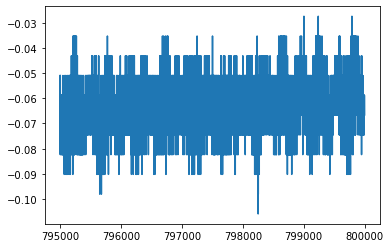

In [34]:
# single range looks like this 
ts_range.plot()

In [59]:
transformed_sig.shape[1]

19

In [16]:
# this code is very simple, divide the total size of the df_train into two sets and process it
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

100%|██████████| 1452/1452 [09:51<00:00,  2.45it/s]


In [11]:
# The X shape here is very important. It is also important undertand a little how a LSTM works
# X.shape[0] is the number of id_measuremts contained in train data
# X.shape[1] is the number of chunks resultant of the transformation, each of this date enters in the LSTM serialized
# This way the LSTM can understand the position of a data relative with other and activate a signal that needs
# a serie of inputs in a specifc order.
# X.shape[3] is the number of features multiplied by the number of phases (3)
print(X.shape, y.shape)
# save data into file, a numpy specific format
np.save("X.npy",X)
np.save("y.npy",y)

(2904, 160, 57) (2904,)


In [12]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(64, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [2]:
# Here is where the training happens

# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

NameError: name 'StratifiedKFold' is not defined

In [1]:
X.shape

NameError: name 'X' is not defined

In [ ]:
# The output of this kernel must be binary (0 or 1), but the output of the NN Model is float (0 to 1).
# So, find the best threshold to convert float to binary is crucial to the result
# this piece of code is a function that evaluates all the possible thresholds from 0 to 1 by 0.01
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    return search_result

In [ ]:
best_threshold = threshold_search(y_val, preds_val)['threshold']

In [ ]:
%%time
# Now load the test data
# This first part is the meta data, not the main data, the measurements
meta_test = pd.read_csv('../input/metadata_test.csv')

In [ ]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

In [ ]:
%%time
# First we daclarete a series of parameters to initiate the loading of the main data
# it is too large, it is impossible to load in one time, so we are doing it in dividing in 10 parts
first_sig = meta_test.index[0]
n_parts = 10
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)
# Here we create a list of lists with start index and end index for each of the 10 parts and one for the last partial part
start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []
# now, very like we did above with the train data, we convert the test data part by part
# transforming the 3 phases 800000 measurement in matrix (160,57)
for start, end in start_end:
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(subset_test.columns):
        id_measurement, phase = meta_test.loc[int(i)]
        subset_test_col = subset_test[i]
        subset_trans = transform_ts(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])

In [ ]:
X_test_input = np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
np.save("X_test.npy",X_test_input)
X_test_input.shape

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
print(len(submission))
submission.head()

In [ ]:
preds_test = []
for i in range(N_SPLITS):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test_input, batch_size=300, verbose=1)
    pred_3 = []
    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [ ]:
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

In [ ]:
submission['target'] = preds_test
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [1]:
50000/80

625.0

In [7]:
from keras.models import load_model
from attention import Attention



model = load_model('attention_model.h5', custom_objects={'Attention': Attention})

TypeError: __init__() missing 1 required positional argument: 'step_dim'